In [1]:
# 텐서플로 2 버전 선택
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import numpy as np


In [2]:
import tensorflow_hub as hub

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [3]:
from tensorflow.keras.applications import MobileNetV2

mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [4]:
import os
import pathlib
# content_data_url = '/content/sample_data'
# data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz', cache_dir=content_data_url, extract=True)
# data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-topimages')
# print(data_root)

data_root = pathlib.Path('./imagenetv2-topimages')

In [5]:
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

imagenetv2-topimages\0
imagenetv2-topimages\1
imagenetv2-topimages\10
imagenetv2-topimages\100
imagenetv2-topimages\101
imagenetv2-topimages\102
imagenetv2-topimages\103
imagenetv2-topimages\104
imagenetv2-topimages\105
imagenetv2-topimages\106


In [6]:
label_file = tf.keras.utils.get_file('label', './label')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


In [7]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)
image_count = len(all_image_paths)
print(image_count)


10000


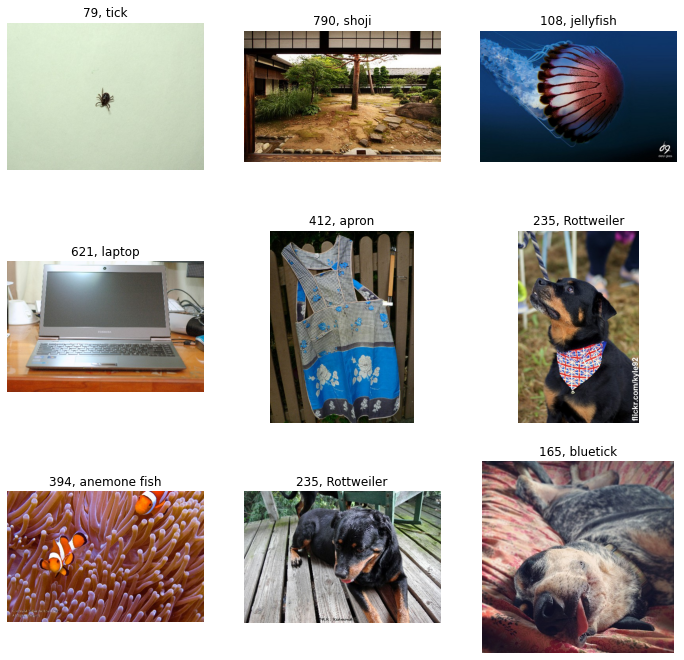

In [8]:
plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('\\')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
plt.show()

In [53]:
import cv2

top_1 = 0
top_5 = 0
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
    idx = int(image_path.split('\\')[-2])+1
    if idx in top_5_predict:
        top_5 += 1
        if top_5_predict[0] == idx:
            top_1 += 1

print('Top-5 correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness:', top_1 / len(all_image_paths) * 100, '%')

Top-5 correctness: 83.84 %
Top-1 correctness: 59.45 %


[808 728 756 418 406]
['airship', 'balloon', 'radio telescope', 'planetarium', 'solar dish']
[946 944 739 955 503]
['clog', 'banana', 'pot', 'cucumber', 'bell pepper']
[427 636 893 869 836]
['sundial', 'tray', 'wall clock', 'magnetic compass', 'barometer']


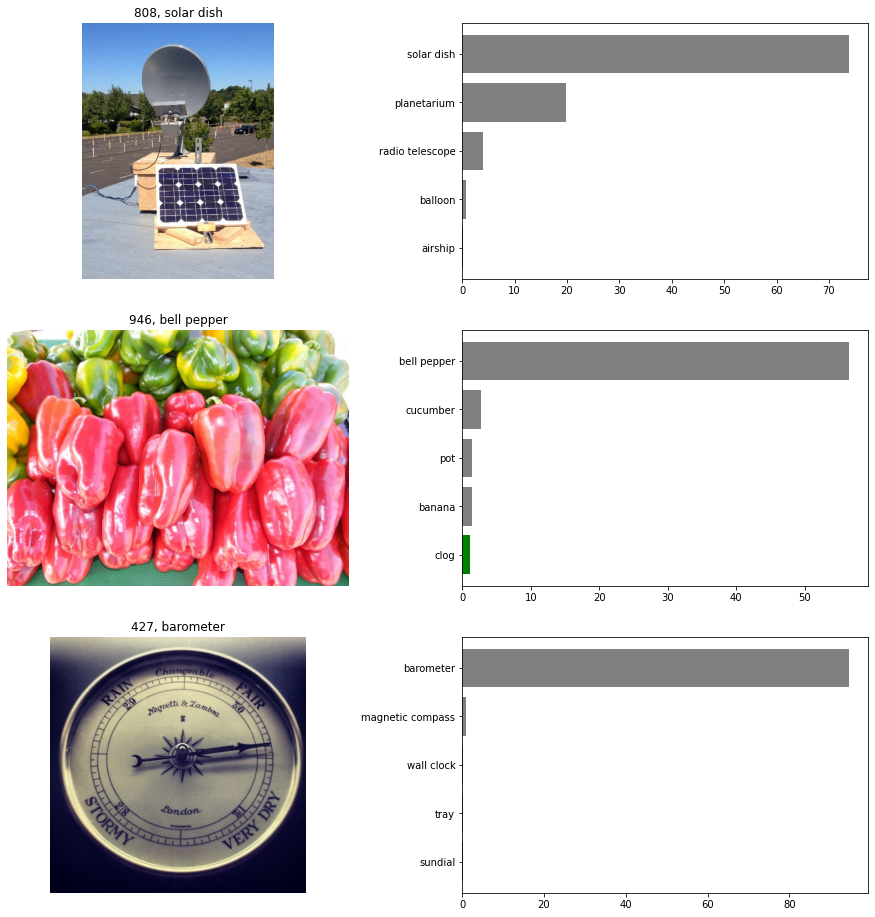

In [17]:
import cv2

plt.figure(figsize=(16,16))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
  
for c in range(3):
    image_path = random.choice(all_image_paths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('\\')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # MobileNet을 이용한 예측
    logits = model.predict(img)[0]
    prediction = softmax(logits)
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    print(top_5_predict)
    labels = [label_text[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    # color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    print(labels[::-1])
    plt.yticks(range(5), labels[::-1]) 